# Appendix: Analysis of Home Sharing's Rio De Janeiro Market

**Summary:**

Understanding one's market is critical to the success of a business. Like a lot of P2P tech companies today (Lyft, eBay, Uber, etc), Home Sharing is a two sided market. As a rule of thumb, most P2P companies focus on supply solutions, rather than demand in their market. Switching costs (time, money, etc), are usually more negligible on the demand side than the supplier side. A potential guest could check a hotel, hostel, crowdsurf, etc, as an alternate source for housing at the touch of a screen. However, it is difficult for the host to just switch platforms, after putting time and effort to make their profile, list their place, get verified, etc. Hence, while both sides of the market are examined in this case study, reccommendations should skew heavily to the host side. The idea is if you build the product and it is good, the demand will come!


# Preliminary Data Investigation

The first step is to investigate and get familiarised with the data set. The primary data set is the contacts csv, consisting of records of requests with listings in Home Sharing's Rio De Janeiro market. Requests are defined as events where guests approach a host to book their listing. It is supported by data records of the listings in Rio De Janeiro, and of the users (both guests and hosts)

1. In the contacts data set, there are nulls in the time stamped columnns, which act as categorical variables. A null is a 0 for an event happening (reply, acceptance, booking), while a time stamp is a 1. There is also one null value in the record for number of guests an inquiry is made for, which can be fixed by simple median imputation. There are 35 records with unknown values for the classification of users into new and old users. At 0.1% of the total records, it is ok to leave these values be.

2. There are no nulls in the listings file. However, there are 41 records where the number of reviews is negative, which is impossible. These are considered to be systematic errors, and their absolute values fall within the range of the upper limits of the data set. Investigations should be made into how the data logging process handles reviews at the extremes.

3. Only 58% of the listings have their neighbourhoods known! As the neighbourhoods where listings occur can garner valuable insight to the market, this is problematic. A later test showed that the sample of listings with known neighbourhoods is not markedly statistically different from the entire population, so this sample can be used to garner insights about our neighbourhoods.

4. The users data set has 68 duplicate records, which are dropped. Also, it has one null in the user origin country column, which is imputed with the mode.


In [200]:
## Import the general libraries for this analysis

import warnings
warnings.simplefilter('ignore')
from IPython.display import clear_output
from operator import itemgetter

## Date time and Analytical Libraries

import math
import datetime as dt
from datetime import datetime
from datetime import timedelta 
import numpy as np
import pandas as pd
import scipy

## Learning Libraries

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

## Visualisation Libraries

import seaborn as sns
import matplotlib.pyplot as plt
import bokeh

clear_output()

In [146]:
## Load contacts csv to dataframe and investigate

contacts_raw_df = pd.read_csv('contacts.csv') 
contacts_raw_df.info()
contacts_missing_list = contacts_raw_df.isnull().sum()
print(contacts_missing_list[contacts_missing_list > 0])

## Explore dataframe for all rows containing any null heading

contacts_raw_df[contacts_raw_df.isnull().any(axis=1)].info() 


## Explore dataframe where booking date, accepted date, reply date, are null
## To explore for different null columns, just change the contacts_column variable to the column you want

contacts_column = 'ts_booking_at'
contacts_nulls_df = contacts_raw_df[contacts_raw_df[contacts_column].isnull()]
contacts_nulls_df.info()

## Check dataframe for duplicates

contacts_duplicate_df = contacts_raw_df
print(contacts_duplicate_df.duplicated().value_counts())

## Explore the Unique entries in each column to examine for erroneous entries

for column in contacts_raw_df.columns:
    contacts_uniques_list = (contacts_raw_df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(contacts_uniques_list)), contacts_uniques_list[:5])
    
contacts_raw_df['m_guests'].unique() ## explore the uniques in a specific column

## Explore the time range of the contacts file

booking_times_list = [x for x in contacts_raw_df['ts_booking_at'].unique() if str(x) != 'nan']
checkin_times_list = [x for x in contacts_raw_df['ds_checkin_first'].unique() if str(x) != 'nan']

print('interaction time range: ',contacts_raw_df['ts_interaction_first'].min(),'to ', \
      contacts_raw_df['ts_interaction_first'].max())
print('booking time range: ',min(booking_times_list), 'to ', max(booking_times_list))
print('checkin time range: ',min(checkin_times_list), 'to ', max(checkin_times_list))

clear_output()

In [147]:
## Load listings csv to dataframe and investigate

listings_raw_df = pd.read_csv('listings.csv')
listings_raw_df.info()
listings_missing_list = listings_raw_df.isnull().sum()
print(listings_missing_list[listings_missing_list > 0])

## Explore the Unique entries in each column to examine for erroneous entries

for column in listings_raw_df.columns:
    listings_uniques_list = (listings_raw_df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(listings_uniques_list)), listings_uniques_list[:5])

## check how many reviews counts are less than zero

listings_raw_df.loc[listings_raw_df['total_reviews'] < 0].info()

## Check dataframe for duplicates

listings_duplicate_df = listings_raw_df
print(listings_duplicate_df.duplicated().value_counts())

clear_output()

In [148]:
## Load users csv to dataframe and investigate

users_raw_df = pd.read_csv('users.csv')
users_raw_df.info()
users_missing_list = users_raw_df.isnull().sum()
print(users_missing_list[users_missing_list > 0])

## Explore the Unique entries in each column to examine for erroneous entries

for column in users_raw_df.columns:
    users_uniques_list = (users_raw_df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(users_uniques_list)), users_uniques_list[:5])
    
## check how many bio counts are less than zero

users_raw_df.loc[users_raw_df['words_in_user_profile'] < 0].info()

## Check dataframe for duplicates

users_duplicate_df = users_raw_df
print(users_duplicate_df.duplicated().value_counts())

clear_output()

# Metrics Definition

The main metrics defined for understanding the market are:

**Booking Rate:**
This is defined as the ratio of interactions that occur in a positive booking to all interactions within a segment.

**Conflict Rate:**
Consider a listing X. n users approach to book x for visit periods that overlap each other. If all n users can't be booked for that time frame, it means that there is a shortfall in supply for those n users. The ratio of the number of conflicting interactions to all interactions within a segment gives us its conflict rate.

**Implementation of Metrics:**
When analysing segments, 4 measures are considered:
1. The ratio of listings within that segment (for host facing factors) to the entire listings, L
2. The ratio of interaction events within the segment to the entire interaction events, i
3. The ratio of bookings events within the segment to the entire bookings, b
4. The proportion of conflicting events, k to the entire conflicts

For a segment, L gives us a measure of the supply within that segment, and i gives a measure of demand. 
Where L ~ i, there is a match of supply and demand
Where b > i, there is a higher booking rate than average, and vice versa.
k gives a measure of surplus demand for a segment. 



In [181]:
## Code: Add extra fields directly to the dataframe

## Create a primary key field in the raw contacts dataframe
## Use the listingid, guest id, and first interaction id to avoid duplicates

contacts_raw_df['primary_key'] = contacts_raw_df["id_listing_anon"].map(str) + \
                                 contacts_raw_df["id_guest_anon"].map(str) + \
                                 contacts_raw_df["ts_interaction_first"].map(str)

## Add a User Type field to the raw users dataframe.
## This classifies users into guest only, user only, or both 

users_raw_df['User_type'] = np.where\
(users_raw_df['id_user_anon'].isin(contacts_raw_df['id_guest_anon'].unique()) & \
 users_raw_df['id_user_anon'].isin(contacts_raw_df['id_host_anon'].unique()), 'both',\
 np.where(users_raw_df['id_user_anon'].isin(contacts_raw_df['id_guest_anon'].unique()), 'guest', 'host'))

## Add the number of bookings and number of interactions for each listing to the raw listings data frame

listings_raw_df['requests'] = listings_raw_df['id_listing_anon'].map\
                (contacts_raw_df['id_listing_anon'].value_counts().to_dict()) 
listings_raw_df['bookings'] = listings_raw_df['id_listing_anon'].map\
                (contacts_raw_df.dropna(subset = ['ts_booking_at'])['id_listing_anon'].value_counts().to_dict())
listings_raw_df['requests'].fillna(0, inplace=True)
listings_raw_df['bookings'].fillna(0, inplace=True)


## Get headers for each dataframe

contacts_headers_list = list(contacts_raw_df.columns.values)
listings_headers_list = list(listings_raw_df.columns.values)
users_headers_list = list(users_raw_df.columns.values)


In [182]:
### Code: create dictionaries to add categorical values for booking outcome


contacts_raw_list = (contacts_raw_df.values.tolist())
contacts_raw_list.sort(key = itemgetter(contacts_headers_list.index('id_listing_anon')))

def make_new_contacts(df_col):
    new_dict = {}
    pri = contacts_headers_list.index('primary_key')
    list_col = contacts_headers_list.index(df_col)
    for row in range(len(contacts_raw_list)):
        if str(contacts_raw_list[row][list_col]) == 'nan':
            new_dict[contacts_raw_list[row][pri]] = 0
        else:
            new_dict[contacts_raw_list[row][pri]] = 1
    return new_dict

bookings_dict = make_new_contacts('ts_booking_at')
accepted_dict = make_new_contacts('ts_accepted_at_first')
        
## Add Metrics Columns to Raw Contacts dataframe

contacts_raw_df['bookings'] = contacts_raw_df['primary_key'].map(bookings_dict)

## Map fields from other dataframes to Raw Contacts Dataframe

contacts_raw_df['neighbourhood'] = contacts_raw_df['id_listing_anon'].map\
                                (listings_raw_df.set_index('id_listing_anon')['listing_neighborhood'].to_dict())

contacts_raw_df['room_type'] = contacts_raw_df['id_listing_anon'].map\
                                (listings_raw_df.set_index('id_listing_anon')['room_type'].to_dict()) 

contacts_raw_df['guest_country'] = contacts_raw_df['id_guest_anon'].map\
                                (users_raw_df.set_index('id_user_anon')['country'].to_dict())

contacts_raw_df['host_country'] = contacts_raw_df['id_host_anon'].map\
                                (users_raw_df.set_index('id_user_anon')['country'].to_dict())

contacts_raw_df['host_bio_length'] = contacts_raw_df['id_guest_anon'].map\
                                (users_raw_df.set_index('id_user_anon')['words_in_user_profile'].to_dict())
    
contacts_raw_df['guest_bio_length'] = contacts_raw_df['id_host_anon'].map\
                                (users_raw_df.set_index('id_user_anon')['words_in_user_profile'].to_dict())
    
listings_raw_df['host_country'] = listings_raw_df['id_listing_anon'].map\
                                (contacts_raw_df.set_index('id_listing_anon')['host_country'].to_dict())

listings_raw_df['host_bio_length'] = listings_raw_df['id_listing_anon'].map\
                                (contacts_raw_df.set_index('id_listing_anon')['host_bio_length'].to_dict())
    
## Update Column Headers Lists for accessing indices

contacts_headers_list = list(contacts_raw_df.columns.values)
listings_headers_list = list(listings_raw_df.columns.values)
users_headers_list = list(users_raw_df.columns.values)


In [151]:
## create a dictionary, visit_dates, containing the listing id as key, 
## visit_dates contains lists of lists of the primary key, check in and check out dates as values


contacts_raw_list = (contacts_raw_df.values.tolist())
contacts_raw_list.sort(key = itemgetter(contacts_headers_list.index('id_listing_anon')))

visit_dates_dict = listings_raw_df['id_listing_anon'].value_counts().to_dict() # initialise dictionary

for listing in visit_dates_dict:
    dates = []
    column = contacts_headers_list.index('id_listing_anon')
    checkin = contacts_headers_list.index('ds_checkin_first')
    checkout = contacts_headers_list.index('ds_checkout_first')
    pri_key = contacts_headers_list.index('primary_key')
    booking_code = contacts_headers_list.index('bookings')
    for row in range(len(contacts_raw_list)):
        if contacts_raw_list[row][column] == listing:
            dates.append([contacts_raw_list[row][checkin],
                          contacts_raw_list[row][checkout],
                          contacts_raw_list[row][pri_key],
                          contacts_raw_list[row][booking_code]])
    visit_dates_dict[listing] = dates
    
    
## create a dictionary of conflict listings, and map to the contacts clean dataframe
## if there is a conflict, return 1, otherwise, 0

conflicts_dict = contacts_raw_df['primary_key'].value_counts().to_dict()

for row in range(len(contacts_raw_list)-1):
    
    answer = 0
    key = contacts_raw_list[row][contacts_headers_list.index('primary_key')]
    listing_id = contacts_raw_list[row][contacts_headers_list.index('id_listing_anon')]
    start = contacts_headers_list.index('ds_checkin_first')
    end = contacts_headers_list.index('ds_checkout_first')
    booked = contacts_headers_list.index('bookings')
    ## if there is only one date pair in visit_dates_dict, it means there was only one listing
    ## hence no conflicts
    if len(visit_dates_dict[listing_id]) == 1:
        answer = 0
        
    else:
        
        ## if the checkin or checkout dates fall within any time ranges it means there is conflict
        ## however, make sure to exclude the date pair of the row we are checking against
        for pair in visit_dates_dict[listing_id]:
            pair_start = dt.datetime.strptime(pair[0], '%Y-%m-%d')
            pair_end = dt.datetime.strptime(pair[1], '%Y-%m-%d')
            visit_start = dt.datetime.strptime(contacts_raw_list[row][start], '%Y-%m-%d')
            visit_end = dt.datetime.strptime(contacts_raw_list[row][end], '%Y-%m-%d')
            
            rule1 = [visit_start < pair_start,
                     visit_end <= pair_start,]
            
            rule2 = [pair[3] == 1,\
                     contacts_raw_list[row][booked] == 1]
            
            if pair[2] == key:
                answer = 0
                
            elif all(rule1) or visit_start >= pair_end:
                answer = 0
                
            elif all(rule2):
                answer = 0
                
            else:
                answer = 1
                
            if answer == 1:
                break
                
    conflicts_dict[key] = answer
    

In [152]:
## Add new fields to data frames and clean up
contacts_raw_df['clashes'] = contacts_raw_df['primary_key'].map(conflicts_dict)
contacts_raw_df['conflicts'] = np.where(contacts_raw_df['bookings'] == 0, contacts_raw_df['clashes'], 0)

listings_raw_df['clashes'] = listings_raw_df['id_listing_anon'].map\
                                (contacts_raw_df[contacts_raw_df['clashes'] == 1]\
                                 ['id_listing_anon'].value_counts().to_dict())
listings_raw_df['clashes'].fillna(0, inplace=True)

listings_raw_df['conflicts'] = listings_raw_df['id_listing_anon'].map\
                                (contacts_raw_df[contacts_raw_df['conflicts'] == 1]\
                                 ['id_listing_anon'].value_counts().to_dict())
listings_raw_df['conflicts'].fillna(0, inplace=True)

## add visit length

contacts_raw_df['length_of_stay'] = pd.to_datetime(contacts_raw_df['ds_checkout_first'])\
                                    - pd.to_datetime(contacts_raw_df['ds_checkin_first'])
contacts_raw_df['length_of_stay'].describe()

## date buckets
day1 = pd.to_datetime('2016-01-02')-pd.to_datetime('2016-01-01')
day3 = pd.to_datetime('2016-01-04')-pd.to_datetime('2016-01-01')
week1 = pd.to_datetime('2016-01-08')-pd.to_datetime('2016-01-01')
week2  = pd.to_datetime('2016-01-15')-pd.to_datetime('2016-01-01')
month = pd.to_datetime('2016-01-29')-pd.to_datetime('2016-01-01')

contacts_raw_df['visit_length'] = np.where(contacts_raw_df['length_of_stay'] <= day1, '(1) one day',
                                            np.where(contacts_raw_df['length_of_stay'] <= day3, '(2) three days',
                                            np.where(contacts_raw_df['length_of_stay'] <= week1, '(3) one week',
                                            np.where(contacts_raw_df['length_of_stay'] <= week2, '(4) two weeks',
                                            np.where(contacts_raw_df['length_of_stay'] <= month , '(5) one month',
                                                     '(6) long stay')))))

## impute mean of m_guests into the null value of m_guests

contacts_raw_df['m_guests'].fillna(contacts_raw_df['m_guests'].median(), inplace=True)
listings_raw_df['total_reviews'] = np.where(listings_raw_df['total_reviews'] < 0,\
                                            listings_raw_df['total_reviews'].abs(),\
                                            listings_raw_df['total_reviews'])
users_raw_df['country'].fillna(users_raw_df['country'].mode(), inplace=True)
users_raw_df.drop_duplicates(inplace = True)

## Update Headers

contacts_headers_list = list(contacts_raw_df.columns.values)
listings_headers_list = list(listings_raw_df.columns.values)
users_headers_list = list(users_raw_df.columns.values)


# Time Trends

Simple time series plots were made to analyse trends in the market. While there was a high amount of interactions in the early part of 2016, with a peak at over 350 a day in mid January, they dropped sharply, then steadied out from February till the end of the time period, fluctuating around 150 a day. 

At first this seemed concerning, so investigations were made into bookings trends. Suprisingly, there is no peak in  bookings per day corresponding to the peak in interactions per day. They fluctuate around 60 bookings a day on average , with actual highs over 90 occuring after May 2016.

With this in mind, the trend in conflicts was investigated as well. As hypothesised, the most conflicts occur within the start of the year, peaking at 120 in early January, with a drop corresponding to the drop in interactions in February, and fluctuating for the rest of the time period.

The hypothesis is that the excess of demand in January was driven by guests trying to attend the Olympics in August, and  Carnival in February. This is confirmed by a time series of check in dates, showing peaks in early February and late July/early August!

In [153]:
def make_time_series_df(df, time_col, date_format, measure, legend):
    ## takes a dataframe, a column name to make time ranges from, its date format as a string,
    ## and a column name to be measured
    
    new_df = df
    stamp = [x for x in new_df[time_col].unique() if str(x) != 'nan']
    lower = datetime.strptime(min(stamp), date_format).date()
    upper = datetime.strptime(max(stamp), date_format).date()
    delta = upper - lower
    time_range = []
    for i in range(delta.days + 1):
        time_range.append(lower + timedelta(i))
    
    time_range_dict = {el:0 for el in time_range}
    new_df['interaction_date'] = pd.to_datetime(new_df[time_col]).dt.date
    
    for key in time_range_dict:
        time_range_dict[key] = new_df[new_df['interaction_date']==key][measure].count()
    
    time_series_dict = {}
    
    for key in time_range_dict:
        new_df_key = key.strftime('%Y, %m, %d')
        time_series_dict[new_df_key] = time_range_dict[key]
    
    date_series = pd.Series(time_series_dict, name=legend)
    date_series.index.name = 'Date'
    output_df = date_series.reset_index()
    
    return output_df

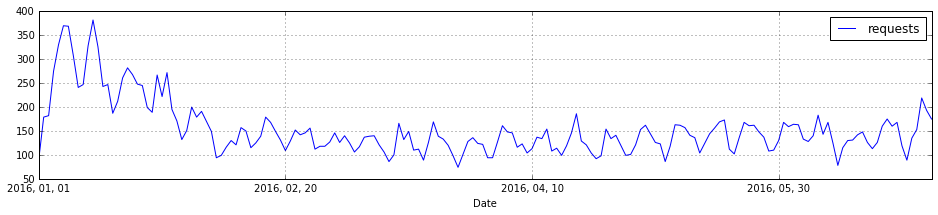

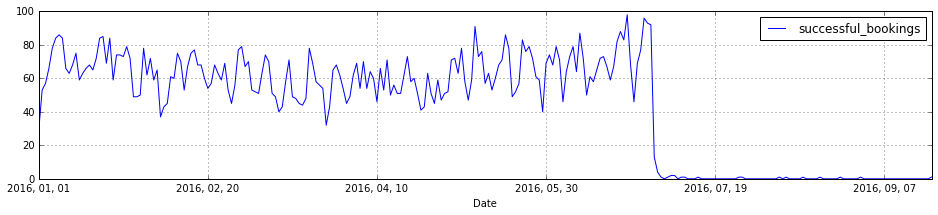

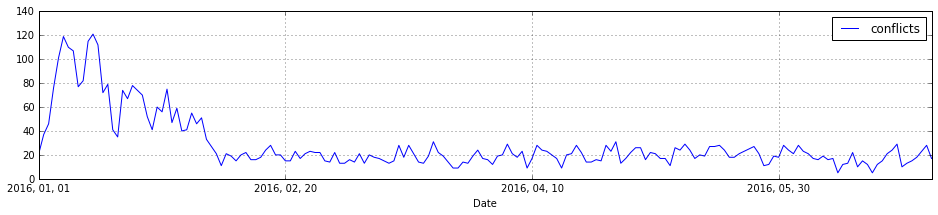

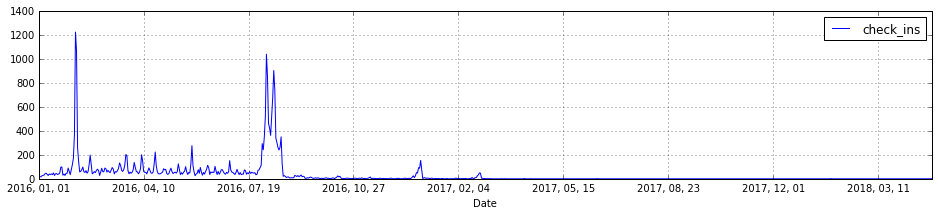

In [154]:
### Repeat Process for Booking Times
%matplotlib inline

interaction_time_series = make_time_series_df(contacts_raw_df,
                                              'ts_interaction_first', 
                                              '%Y-%m-%d %H:%M:%S', 
                                              'primary_key', 
                                              'requests')

bookings_time_series = make_time_series_df(contacts_raw_df[contacts_raw_df['bookings'] == 1],
                                              'ts_booking_at', 
                                              '%Y-%m-%d %H:%M:%S.%f', 
                                              'primary_key', 
                                              'successful_bookings')

conflicts_time_series = make_time_series_df(contacts_raw_df[contacts_raw_df['conflicts'] == 1],
                                              'ts_interaction_first', 
                                              '%Y-%m-%d %H:%M:%S', 
                                              'primary_key', 
                                              'conflicts')

checkin_time_series = make_time_series_df(contacts_raw_df,
                                              'ds_checkin_first', 
                                              '%Y-%m-%d', 
                                              'primary_key', 
                                              'check_ins')

interaction_time_series.plot(x='Date', y='requests', figsize=(16,3), grid= True)
bookings_time_series.plot(x='Date', y='successful_bookings', figsize=(16,3), grid= True)
conflicts_time_series.plot(x='Date', y='conflicts', figsize=(16,3), grid= True)
checkin_time_series.plot(x='Date', y='check_ins', figsize=(16,3), grid= True)



# Market Segmentation

In [192]:
## create function to make a dataframe with columns as column stacks for the plots

def clustered_bar_with_listings_df(source_df, segment_col, plot_col, **options):
    ## kwargs:
    ## top (boolean return true, if x top items are selected)
    ## top_num (x top items)

    builder_dict = {el:[] for el in source_df[segment_col].unique()}
    
    for key in builder_dict:
        builder_df = source_df[source_df[segment_col] == key]

        listings = int(builder_df['id_listing_anon'].count())
        requests = int(builder_df['requests'].sum())
        bookings = int(builder_df['bookings'].sum())
        conflicts = int(builder_df['conflicts'].sum())
        builder_dict[key] = ([listings, requests, bookings, conflicts])
            
            
    ## get the top x segments
    
    if options.get('top') == True:
        top = min(len(builder_dict), options.get('top_num'))
        bookings = {}
        for key in builder_dict:
            bookings[key] = builder_dict[key][2]
        
        top_builder_dict = dict(sorted(bookings.items(), key=itemgetter(1), reverse=True) [:top-1])
        
    ## rollup the rest
    
        rollup = {}
        rollup['rollup of others'] = [0,0,0,0] ## make a dict of zeroes the length of the dict
        for key in builder_dict:
            if key in top_builder_dict.keys():
                rollup[key] = builder_dict[key]
            else:
                rollup['rollup of others'] = [sum(x) for x in zip(\
                                                                  rollup['rollup of others'],
                                                                  builder_dict[key])]
    ## Set the builder dict to this dict with rollups
    
        builder_dict = rollup
          
    ## get the proportions and make the final DF
    
    totals = [max(source_df['id_listing_anon'].count(),1),
              max(source_df['requests'].sum(),1),
              max(source_df['bookings'].sum(),1),
              max(source_df['conflicts'].sum(),1)]
    
    for key in builder_dict:
        builder_dict[key] = [100*(x/y) for x,y in zip(builder_dict[key], totals)]

    plot_df = pd.DataFrame(builder_dict).transpose()
    plot_df.reset_index()
    plot_df.columns = ["listings", "requests", "bookings", 'conflicts']
    plot_df[plot_col] = plot_df.index
    
    return plot_df


def clustered_bar_with_contacts_df(source_df, segment_col, plot_col, **options):
    ## kwargs:
    ## listings
    ## top (boolean return true, if x top items are selected)
    ## top_num (x top items)

    builder_dict = {el:[] for el in source_df[segment_col].unique()}
    
    for key in builder_dict:
        builder_df = source_df[source_df[segment_col] == key]
        
        if options.get('listings') == True:
            listings = int(len(builder_df['id_listing_anon'].unique()))
            requests = int(builder_df['primary_key'].count())
            bookings = int(builder_df['bookings'].sum())
            conflicts = int(builder_df['conflicts'].sum())
            builder_dict[key] = ([listings, requests, bookings, conflicts])
            
        elif options.get('listings') == False:
            requests = int(builder_df['primary_key'].count())
            bookings = int(builder_df['bookings'].sum())
            conflicts = int(builder_df['conflicts'].sum())
            builder_dict[key] = ([requests, bookings, conflicts])
            
            
    ## get the top x segments
    
    if options.get('top') == True:
        top = min(len(builder_dict), options.get('top_num'))
        bookings = {}
        for key in builder_dict:
            bookings[key] = builder_dict[key][2]
        
        top_builder_dict = dict(sorted(bookings.items(), key=itemgetter(1), reverse=True) [:top-1])
        
    ## rollup the rest
    
        rollup = {}
        
        if options.get('listings') == True:
            rollup['rollup of others'] = [0,0,0,0] ## make a dict of zeroes the length of the dict
        elif options.get('listings') == False:
            rollup['rollup of others'] = [0,0,0]
            
        for key in builder_dict:
            if key in top_builder_dict.keys():
                rollup[key] = builder_dict[key]
            else:
                rollup['rollup of others'] = [sum(x) for x in zip(rollup['rollup of others'], builder_dict[key])]
    ## Set the builder dict to this dict with rollups
    
        builder_dict = rollup
          
    ## get the proportions and make the final DF
    
    if options.get('listings') == True:
        totals = [max(len(source_df['id_listing_anon'].unique()),1),
                  max(source_df['primary_key'].count(),1),
                  max(source_df['bookings'].sum(),1),
                  max(source_df['conflicts'].sum(),1)]
    
    elif options.get('listings') == False:
        totals = [max(source_df['primary_key'].count(),1),
                  max(source_df['bookings'].sum(),1),
                  max(source_df['conflicts'].sum(),1)]
    
    for key in builder_dict:
        builder_dict[key] = [100*(x/y) for x,y in zip(builder_dict[key], totals)]

    plot_df = pd.DataFrame(builder_dict).transpose()
    plot_df.reset_index()
    
    if options.get('listings') == True:
        plot_df.columns = ["listings", "requests", "bookings", 'conflicts']
    elif options.get('listings') == False:
        plot_df.columns = ["requests", "bookings", 'conflicts']
        
    plot_df[plot_col] = plot_df.index
    
    return plot_df



In [193]:
## define a function to plot the clustered columns

def plot_clustered_charts(plot_df, plot_col, fig_length, fig_width, font_size, rot, chart_title):
    %matplotlib inline

    # Setting the positions and width for the bars
    pos = list(range(len(plot_df[plot_col]))) 
    width = 1 / (len(list(plot_df.columns.values)) + 0.5)
    
    # set parameters
    column = list(plot_df.columns.values)[:-1]
    y_top = 0
    for i in column:
        y_top = max(y_top, plot_df[i].max())
    if len(column) == 4:
        colours = ['#900C3F', '#FFC222', '#DAF7A6', '#EE3224']
    else: 
        colours = ['#FFC222', '#DAF7A6', '#EE3224']
        
    # Plotting the bars
    fig, ax = plt.subplots(figsize=(fig_length, fig_width))
    
    # Create a bar with a data frame col for each position
    for i in range(len(column)):
        
        plt.bar([p + (width*i) for p in pos], 
        #using df['column'] data,
        plot_df[column[i]], 
        # of width
        width, 
        # with alpha 0.4
        alpha= width*2, 
        # with color
        color=colours[i]  , 
        # with label the first value in first_name
        label=plot_df[column[i]]) 
        
    
    # Set the y axis label
    ax.set_ylabel('% mix', fontsize = font_size)

    # Set the chart's title
    ax.set_title(chart_title, fontsize=font_size)

    # Set the position of the x ticks
    ax.set_xticks([p + ((len(column)/2) * width) for p in pos])

    # Set the labels for the x ticks
    ax.set_xticklabels(plot_df[plot_col],rotation=rot, fontsize=font_size)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width, max(pos)+width*(len(column)+1.5))
          
    plt.ylim([0, y_top + 5])

    # Adding the legend and showing the plot
    plt.legend(column, loc='best')
    plt.grid()
    plt.show()
    

### Neighbourhoods

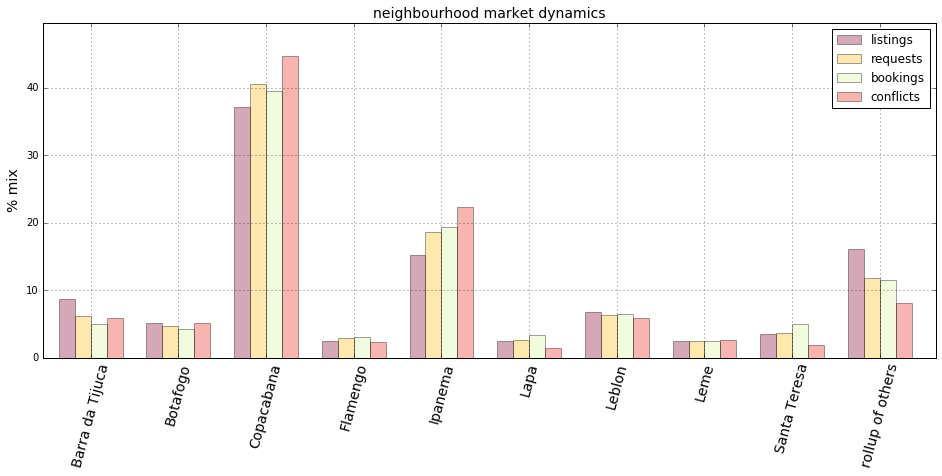

In [157]:
## make a dictionary of neighbourhoods containing the sums of listings, interactions, bookings, and surpluses

listings_partial_df = listings_raw_df[listings_raw_df['listing_neighborhood'] != '-unknown-']
neighbourhood_plot_df = clustered_bar_with_listings_df(listings_partial_df, 'listing_neighborhood',\
                                                       'neighbourhood', top = True, top_num = 10)
plot_clustered_charts(neighbourhood_plot_df, 'neighbourhood', 16, 6, 14, 75, 'neighbourhood market dynamics')

### Room Type

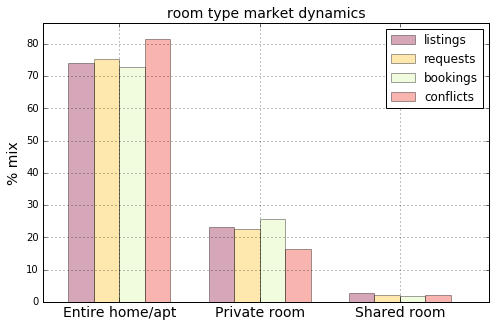

In [158]:
## code to plot metrics by roomtype

room_type_plot_df = clustered_bar_with_listings_df(listings_raw_df, 'room_type', 'room type')

plot_clustered_charts(room_type_plot_df, 'room type', 8, 5, 14, 0, 'room type market dynamics')

### Contact Channel Market Dynamics

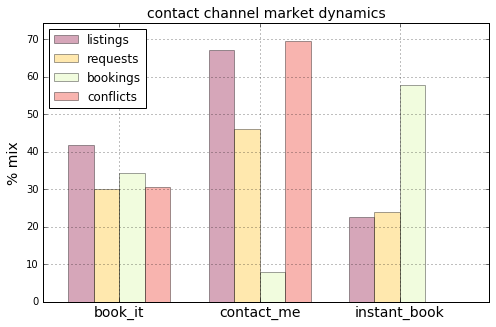

In [159]:
## code to plot metrics by contact channel

channel_plot_df = clustered_bar_with_contacts_df(contacts_raw_df, 'contact_channel_first', 'channel', listings = True)

plot_clustered_charts(channel_plot_df, 'channel', 8, 5, 14, 0, 'contact channel market dynamics')

### Total reviews

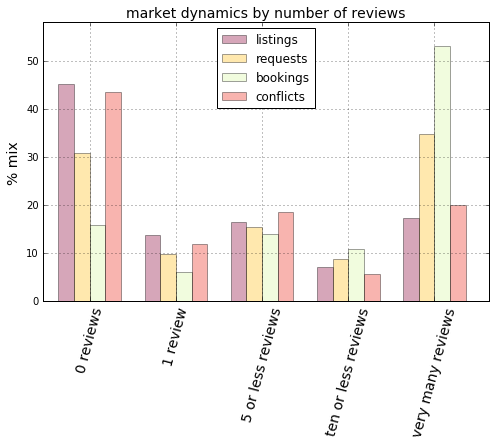

In [160]:
## code to plot metrics by number of reviews

contacts_raw_df['reviews'] = contacts_raw_df['id_listing_anon'].map\
                                (listings_raw_df.set_index('id_listing_anon')['total_reviews'].to_dict())

## Categorize Reviews
contacts_raw_df['review_type'] = np.where(contacts_raw_df['reviews'] == 0, '0 reviews',
                                            np.where(contacts_raw_df['reviews'] == 1, '1 review',
                                            np.where(contacts_raw_df['reviews'] <= 5, '5 or less reviews',
                                            np.where(contacts_raw_df['reviews'] <= 10, 'ten or less reviews',
                                            'very many reviews'))))


review_plot_df = clustered_bar_with_contacts_df(contacts_raw_df, 'review_type', 'reviews', listings = True)

plot_clustered_charts(review_plot_df, 'reviews', 8, 5, 14, 75, 'market dynamics by number of reviews')    

### Number of guests

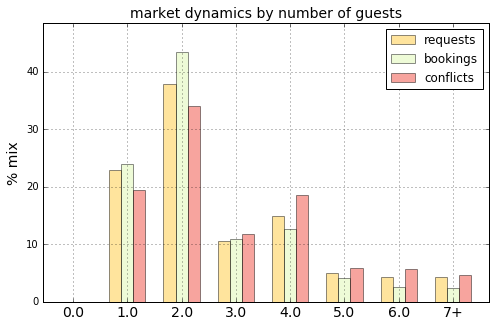

In [161]:
## Code Manipulation to make number of guests plotting dataframe

contacts_raw_df['guests'] = np.where(contacts_raw_df['m_guests'] <= 6, contacts_raw_df['m_guests'], '7+',)


## code to plot metrics by number of guests

guests_plot_df = clustered_bar_with_contacts_df(contacts_raw_df, 'guests', 'guests', listings = False)

plot_clustered_charts(guests_plot_df, 'guests', 8, 5, 14, 0, 'market dynamics by number of guests')

### Duration of Stay

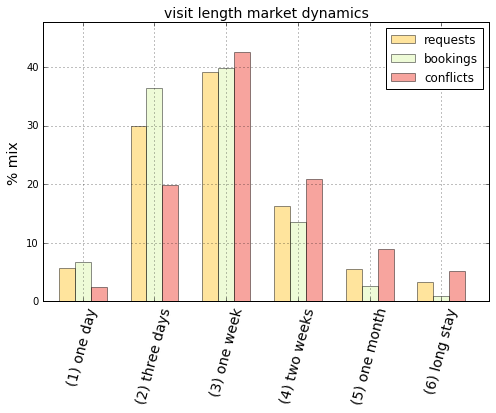

In [162]:
## code to plot metrics by visit length

visit_plot_df = clustered_bar_with_contacts_df(contacts_raw_df, 'visit_length', 'visit', listings = False)

plot_clustered_charts(visit_plot_df, 'visit', 8, 5, 14, 75, 'visit length market dynamics')

### Guest Origin Country

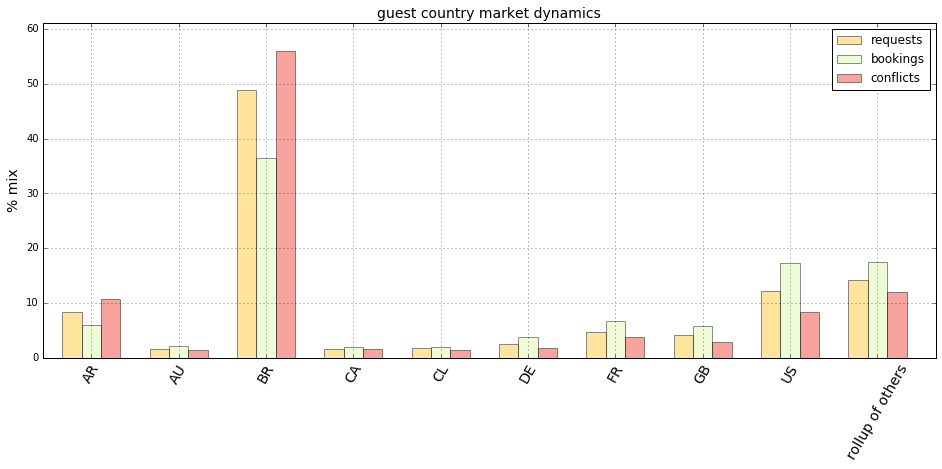

In [173]:
## code to plot metrics by contact channel

country_plot_df = clustered_bar_with_contacts_df(contacts_raw_df, 'guest_country', 'country',
                                                 top = True, top_num = 10, listings = False)

plot_clustered_charts(country_plot_df, 'country', 16, 6, 14, 60, 'guest country market dynamics')

# Machine Learning

I am using ML in this case to help evaluate feature importance with respect to booking outcomes. As such, a random forest estimator was selected. It's default parameters are usually close to the best without much tuning, it deals well with outliers and irrelevant variables, saving preprocessing time.  

In [165]:
## make sure the headers are good

contacts_headers_list = list(contacts_raw_df.columns.values)
listings_headers_list = list(listings_raw_df.columns.values)
users_headers_list = list(users_raw_df.columns.values)


In [166]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()
clear_output()

In [167]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(contacts_raw_df)

h2o_df['bookings'] = h2o_df['bookings'].asfactor()

h2o_df.summary()
clear_output()

In [169]:
# Split into 75% training and 25% test dataset, set features
strat_split = h2o_df['bookings'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

contacts_headers_list = list(contacts_raw_df.columns.values)
feature = contacts_headers_list
remove =['id_guest_anon', 'id_host_anon','id_listing_anon', 'ts_interaction_first', 'ts_reply_at_first',\
         'ts_accepted_at_first', 'ts_booking_at', 'ds_checkin_first', 'ds_checkout_first',\
         'primary_key','bookings', 'host_country', 'clashes', 'length_of_stay',\
         'interaction_date', 'reviews', 'guests']

for i in remove:
    feature.remove(i)

target = 'bookings'

In [170]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


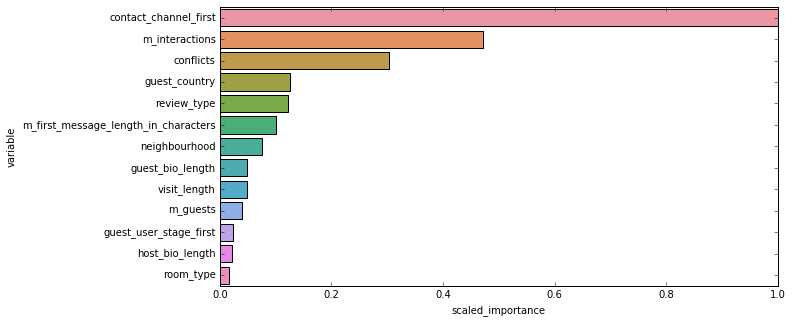

In [171]:
# Plot Scaled Variable importance

%matplotlib inline

importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [172]:
# Make predictions
train_true = train.as_data_frame()['bookings'].values
test_true = test.as_data_frame()['bookings'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [174]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

             precision    recall  f1-score   support

          0       0.93      0.95      0.94      4075
          1       0.93      0.90      0.92      2897

avg / total       0.93      0.93      0.93      6972



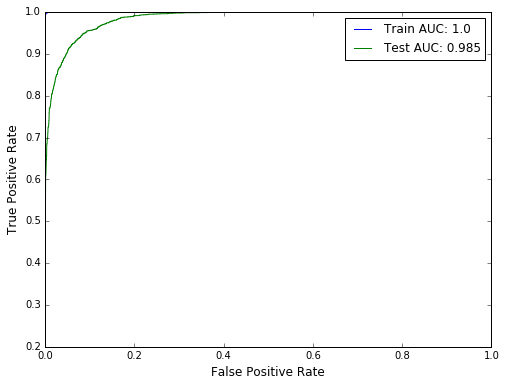

In [175]:
#Plot AUC

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


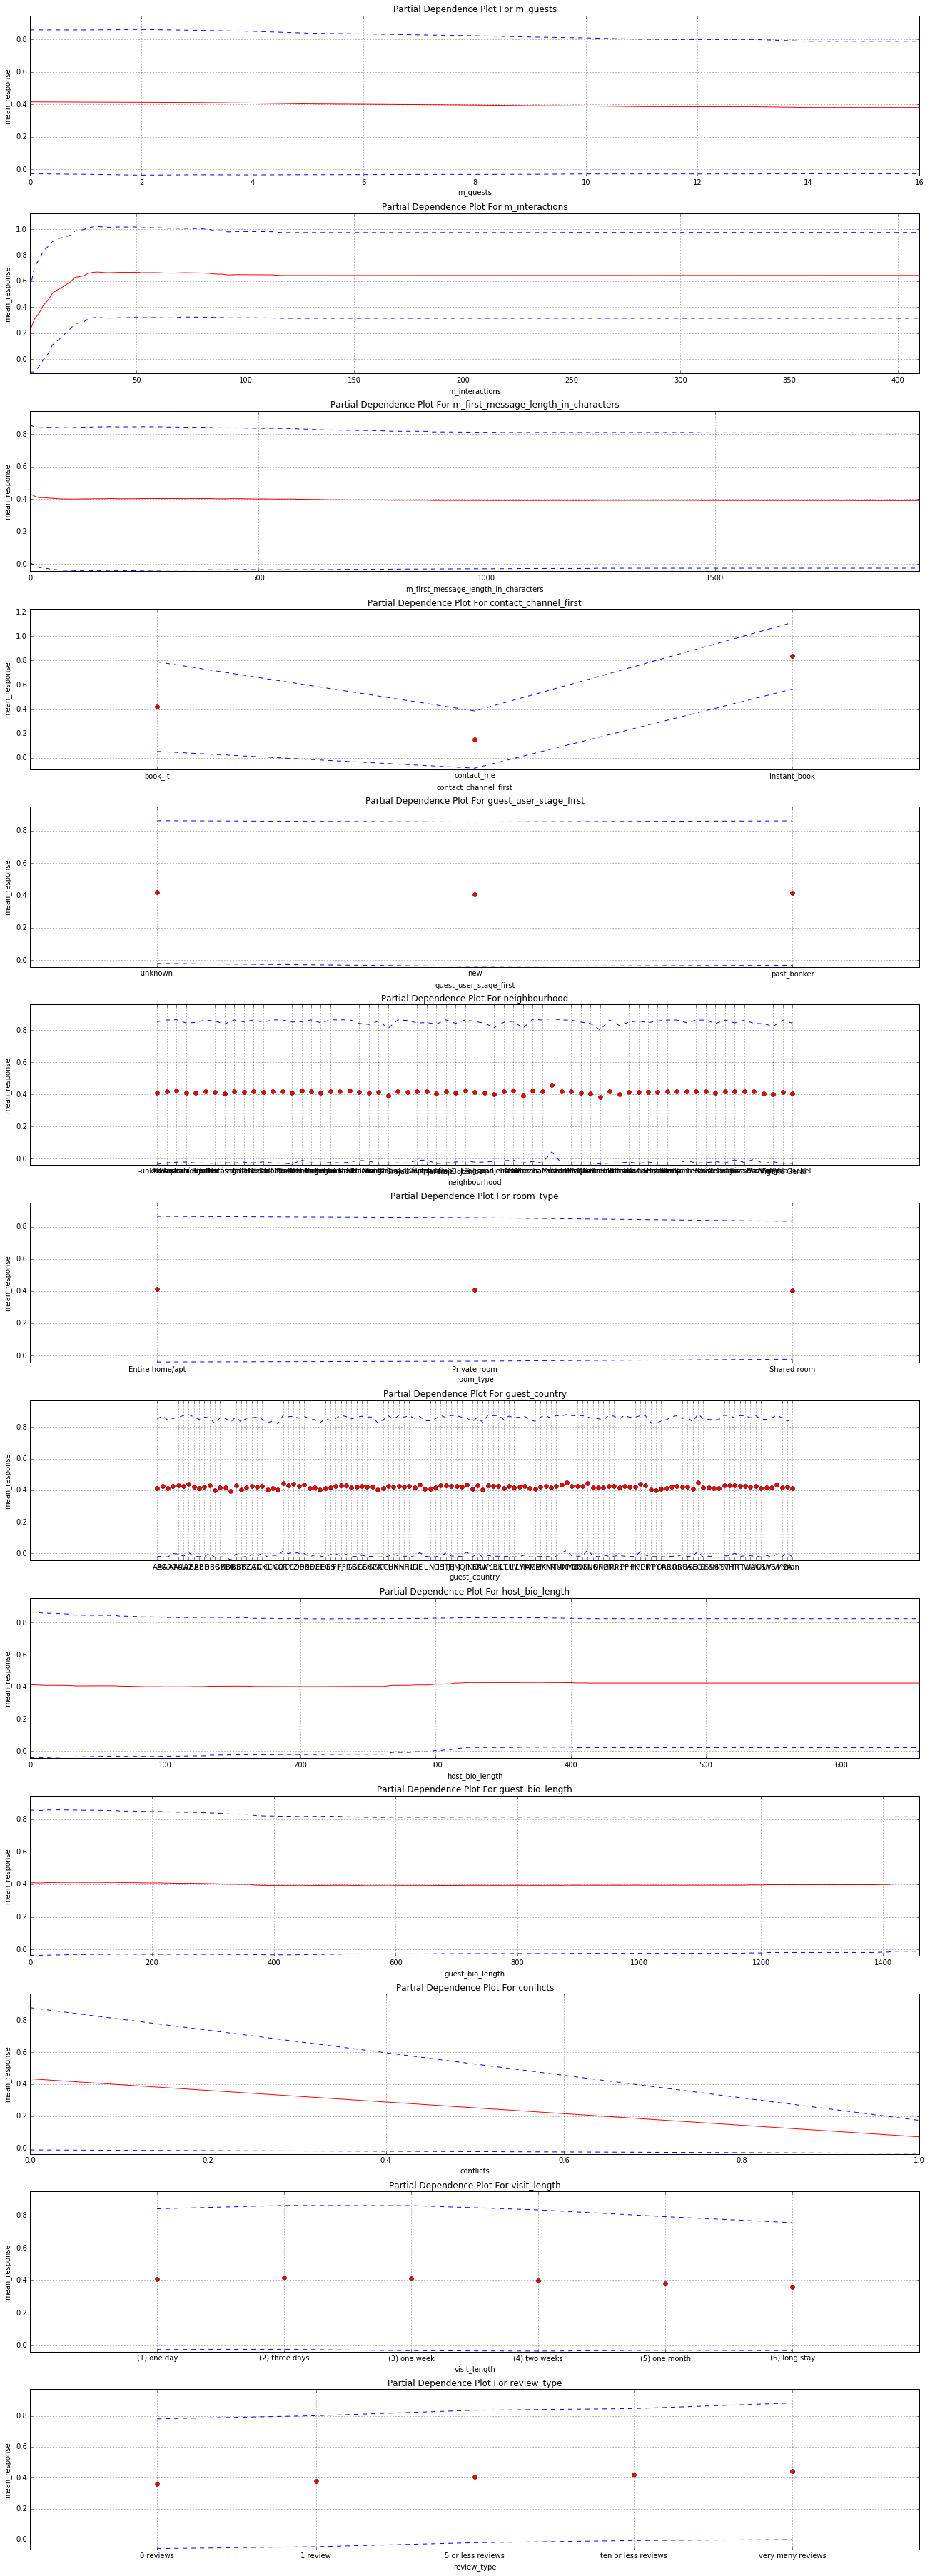

In [176]:
_ = model.partial_plot(train, cols=feature, nbins = 200, figsize=(18, 50))

In [197]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_bf65 closed.
